# Male of Female

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt
import matplotlib

plt.style.use(['seaborn-paper'])
#matplotlib.rc('font', **font)

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# set random seed
np.random.seed(42)

### Generate Data

In [4]:
height_f = np.random.normal(loc=160, scale=10, size=6000)
height_m = np.random.normal(loc=180, scale=15, size=6000)

In [5]:
hair_f = np.random.normal(loc=20, scale=10, size=6000)
hair_m = np.random.normal(loc=5, scale=2, size=6000)

In [6]:
df_m = pd.DataFrame({'hair': hair_m, 'height': height_m, 'sex': np.repeat(1, 6000)})
df_f = pd.DataFrame({'hair': hair_f, 'height': height_f, 'sex': np.repeat(0, 6000)})

In [7]:
df = pd.concat([df_m, df_f], axis=0, ignore_index=True)

In [8]:
df['hair'] = np.where(df['hair'] < 0, 0 , df['hair'])
df['height'] = np.where(df['height'] < 120, 120, df['height'] )
df['height'] = np.where(df['height'] > 220, 220, df['height'] )

In [9]:
df.describe()

,hair,height,sex
count,12000.000000,12000.000000,12000.000000
mean,12.671706,169.909700,0.500000
std,10.454977,16.174742,0.500021
min,0.000000,121.163996,0.000000
25%,4.677372,158.176041,0.000000
50%,7.567095,167.795818,0.500000
75%,20.318668,180.490088,1.000000
max,64.790843,220.000000,1.000000


In [10]:
df.groupby('sex').describe().T

sex                     0            1
hair   count  6000.000000  6000.000000
       mean     20.352876     4.990536
       std       9.833779     1.976783
       min       0.000000     0.000000
       25%      13.418900     3.604894
       50%      20.319497     4.982797
       75%      27.066147     6.349340
       max      64.790843    12.884662
height count  6000.000000  6000.000000
       mean    159.968787   179.850613
       std       9.984125    15.030933
       min     127.587327   121.163996
       25%     153.364687   169.783494
       50%     160.019535   179.719048
       75%     166.568560   190.043868
       max     199.262377   220.000000

In [11]:
X, y = df.drop(['sex'], axis=1), df['sex']

In [12]:
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, stratify=y,  test_size=0.4)

In [13]:
X_test, X_val, y_test, y_val = train_test_split(X_test_temp, y_test_temp, stratify=y_test_temp,  test_size=0.5)

## Build a model

In [30]:
clf = LogisticRegression()

In [31]:
clf.fit(X_train, y_train)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
y_pred = clf.predict(X_val)

In [33]:
y_pred

array([0, 0, 0, ..., 1, 0, 1])

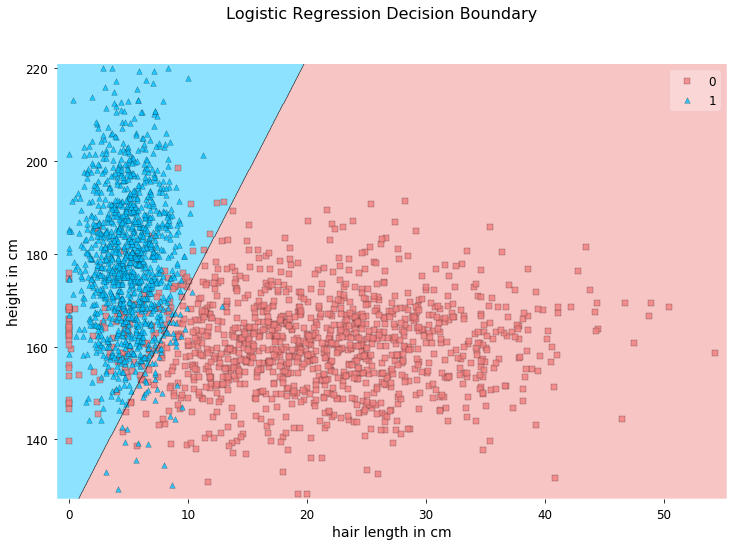

In [34]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=X_val.values, y=y_val.values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True )
fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
fig.savefig('Decision_Boundary.pdf', bbox_inches='tight')

In [35]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1200
           1       0.90      0.96      0.93      1200

   micro avg       0.93      0.93      0.93      2400
   macro avg       0.93      0.93      0.93      2400
weighted avg       0.93      0.93      0.93      2400



### Distributions of the test data

In [20]:
df_test = X_test.copy()
df_test['sex'] = y_test

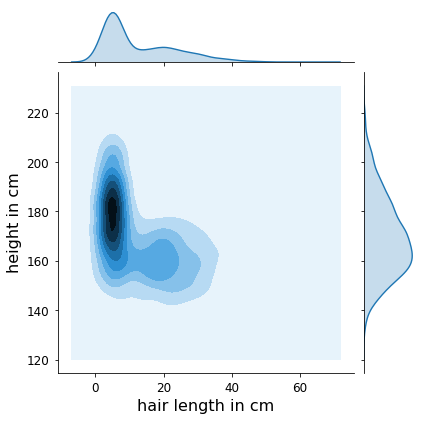

In [21]:
# p(x)
g = sns.jointplot(data=df_test, x='hair', y='height', kind='kde')
g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
g.savefig('joint_px.pdf', bbox_inches='tight')

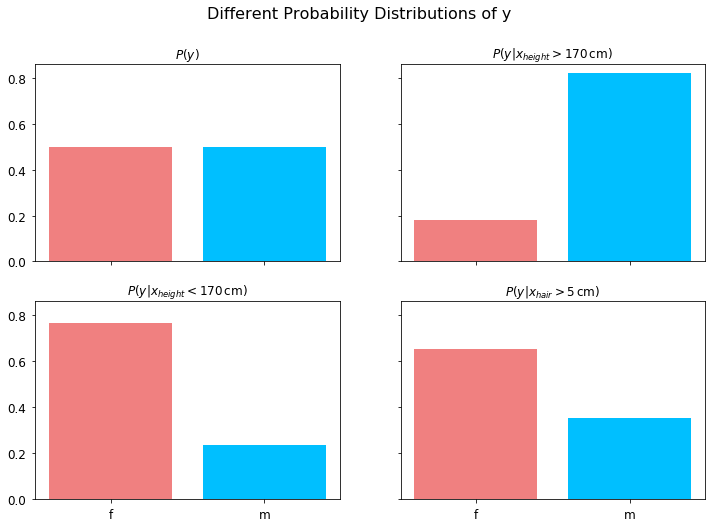

In [91]:
# p(y)

counts_full = df_test['sex'].value_counts(normalize=True)
counts_cond1 = df_test[df_test['height'] > 170]['sex'].value_counts(normalize=True).sort_values()
counts_cond2 = df_test[df_test['height'] < 170]['sex'].value_counts(normalize=True)
counts_cond3 = df_test[df_test['hair'] > 5]['sex'].value_counts(normalize=True)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle("Different Probability Distributions of y")
ax[0,0].bar(x=['f', 'm'], height=counts_full.values, color=['lightcoral','deepskyblue'])
ax[0,1].bar(x=['f', 'm'], height=counts_cond1.values, color=['lightcoral','deepskyblue'])
ax[1,0].bar(x=['f', 'm'], height=counts_cond2.values, color=['lightcoral','deepskyblue'])
ax[1,1].bar(x=['f', 'm'], height=counts_cond3.values, color=['lightcoral','deepskyblue'])

ax[0,0].set_title(r'$P(y)$')
ax[0,1].set_title(r'$P(y\vert x_{height} > 170 \, \mathrm{cm})$')
ax[1,0].set_title(r'$P(y\vert x_{height} < 170\, \mathrm{cm})$')
ax[1,1].set_title(r'$P(y\vert x_{hair} > 5\, \mathrm{cm})$')

fig.savefig('cond_py.pdf', bbox_inches='tight')

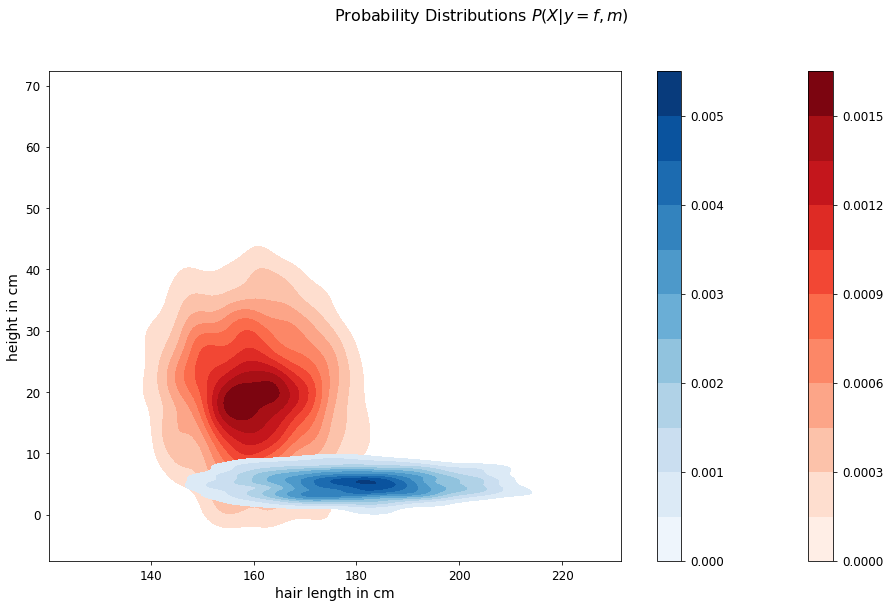

In [95]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test[df_test['sex'] == 1]
df_f = df_test[df_test['sex'] == 0]
sns.kdeplot(df_f['height'], df_f['hair'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['height'], df_m['hair'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )
fig.suptitle(r"Probability Distributions $P(X\vert y=f,m)$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_px.pdf', bbox_inches='tight')
#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

### Szenario 1: All Females grow more than 15% due to some weird pill. Simultaneously they loose some hair (-10%)

In [24]:
df_test_1 = df_test.copy()

In [25]:
female_cond = df_test_1['sex'] == 0
df_test_1.loc[female_cond, 'height'] =  df_test_1.loc[female_cond, 'height'] * 1.15
df_test_1.loc[female_cond, 'hair'] =  df_test_1.loc[female_cond, 'hair'] * 0.90

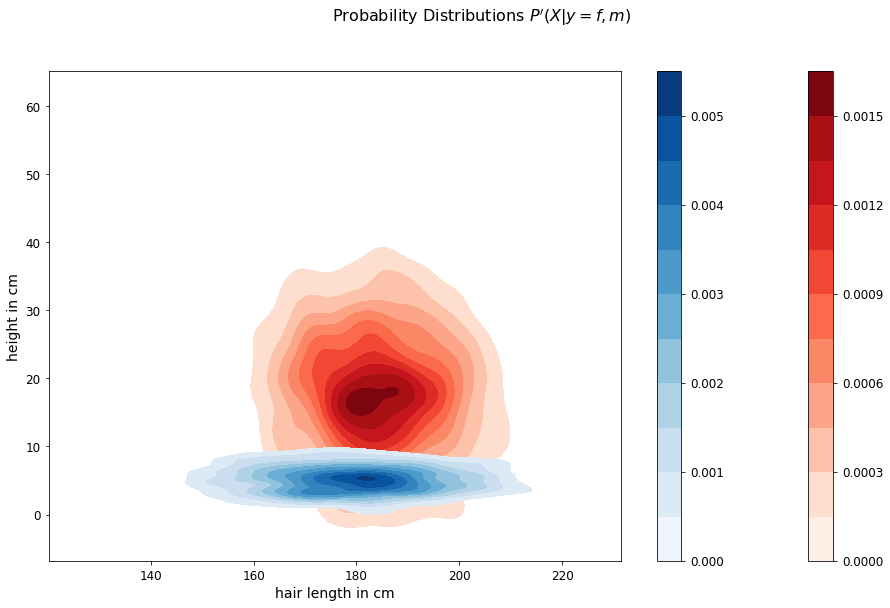

In [26]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test_1[df_test['sex'] == 1]
df_f = df_test_1[df_test['sex'] == 0]
sns.kdeplot(df_f['height'], df_f['hair'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['height'], df_m['hair'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )

fig.suptitle(r"Probability Distributions $P'(X\vert y=f,m)$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_pprimex.pdf', bbox_inches='tight')


#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

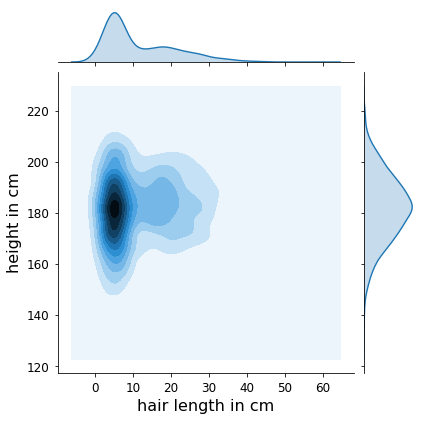

In [100]:
# p(x)
g = sns.jointplot(data=df_test_1, x='hair', y='height', kind='kde')
g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
#g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
g.savefig('joint_pprimex.pdf', bbox_inches='tight')

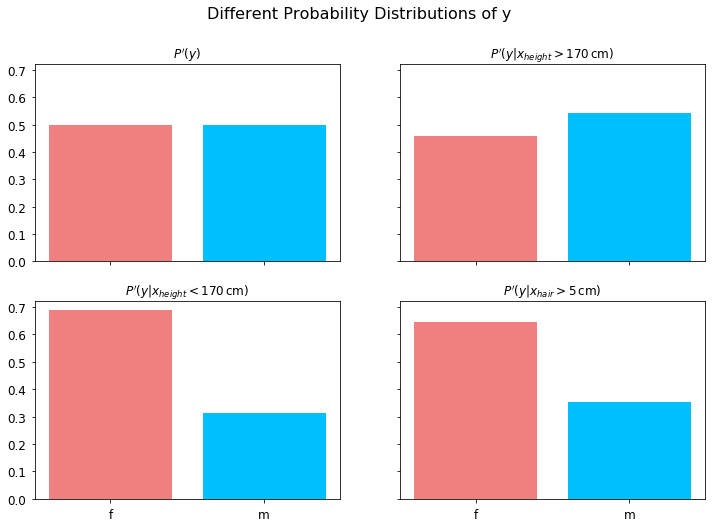

In [27]:
# p(y)

counts_full = df_test_1['sex'].value_counts(normalize=True)
counts_cond1 = df_test_1[df_test_1['height'] > 170]['sex'].value_counts(normalize=True).sort_values()
counts_cond2 = df_test_1[df_test_1['height'] < 170]['sex'].value_counts(normalize=True)
counts_cond3 = df_test_1[df_test_1['hair'] > 5]['sex'].value_counts(normalize=True)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle("Different Probability Distributions of y")
ax[0,0].bar(x=['f', 'm'], height=counts_full.values, color=['lightcoral','deepskyblue'])
ax[0,1].bar(x=['f', 'm'], height=counts_cond1.values, color=['lightcoral','deepskyblue'])
ax[1,0].bar(x=['f', 'm'], height=counts_cond2.values, color=['lightcoral','deepskyblue'])
ax[1,1].bar(x=['f', 'm'], height=counts_cond3.values, color=['lightcoral','deepskyblue'])

ax[0,0].set_title(r"$P'(y)$")
ax[0,1].set_title(r"$P'(y\vert x_{height} > 170 \, \mathrm{cm})$")
ax[1,0].set_title(r"$P'(y\vert x_{height} < 170\, \mathrm{cm})$")
ax[1,1].set_title(r"$P'(y\vert x_{hair} > 5\, \mathrm{cm})$")

fig.savefig('cond_pprimey.pdf', bbox_inches='tight')

Text(0, 0.5, 'height in cm')

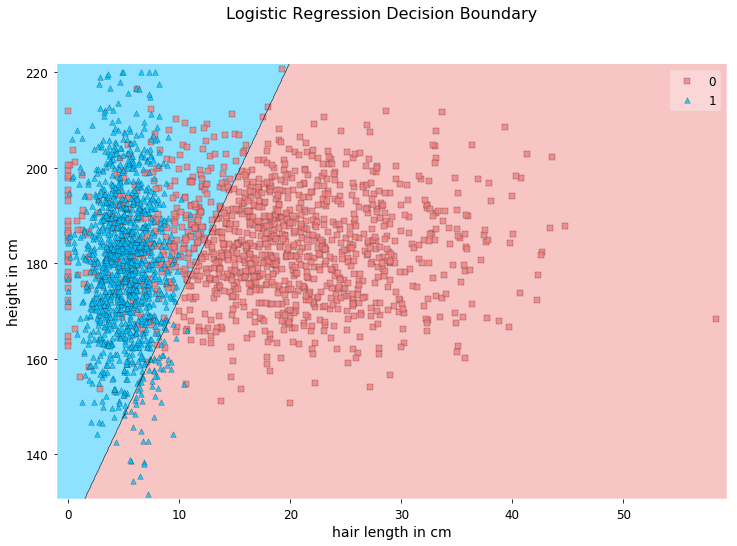

In [36]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True )
fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
#fig.savefig('Decision_Boundary.pdf', bbox_inches='tight')

In [37]:
clf_new_1 = LogisticRegression()

In [38]:
clf_new_1.fit(df_test_1[['hair', 'height']].values, df_test_1['sex'].values)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

[]

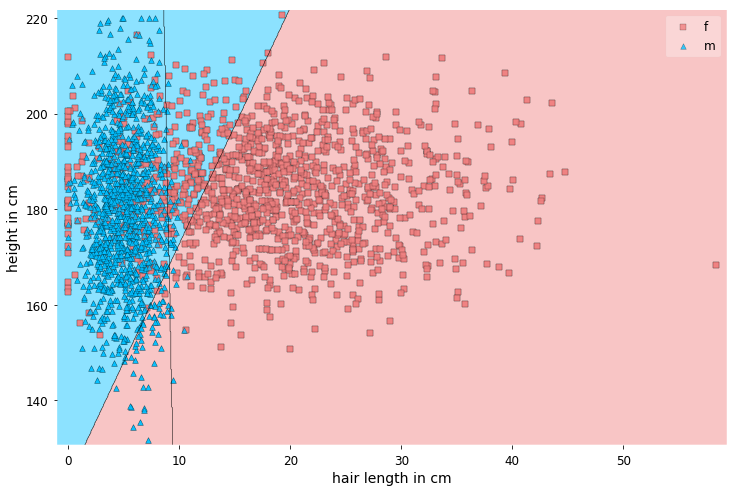

In [139]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True, contourf_kwargs={'linestyles':['dotted', 'dotted']} )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['f', 'm'], 
           framealpha=0.3, scatterpoints=1)
#norml = colors.BoundaryNorm(lev, 256)
plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf_new_1, ax=ax, colors='lightcoral,deepskyblue', legend=False, contourf_kwargs={'alpha':0.0, 'norm':'default'})
#fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
fig.savefig('Decision_Boundary_prime.pdf', bbox_inches='tight')
ax.lines

### bayes

$$P'(Y\vert X) = \frac{P'(X\vert Y) P'(Y)}{P'(X)} = \frac{P'(X\vert Y) P(Y)}{P'(X)}$$

The only terms where we can observe the changes are: $P'(X)$ and the output distribution of our model $F(\hat{y}=f(x))$.

In [79]:
# how early can we detect the change?

In [83]:
proba_hist = clf.predict_proba(X_val)[:,0]
proba_new = clf.predict_proba(df_test_1[['hair', 'height']])[:,0]

In [91]:
proba_new.max()

0.999999997429202

In [93]:
proba_comb = np.concatenate([proba_hist,proba_new])

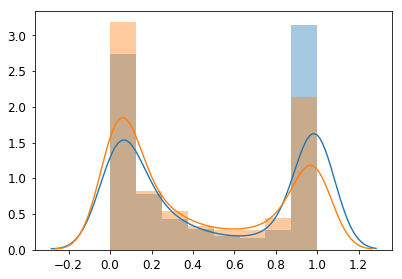

In [96]:
sns.distplot(proba_hist)
sns.distplot(proba_new)

In [97]:
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in proba_new:
    samples.append(element)
    k, p = ks_2samp(proba_hist, samples)
    ks_stats.append(p)

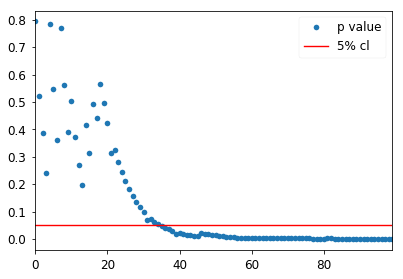

In [112]:
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- we can detect the concept drift since we predict more men than women now
- this does not mean that there is actually a concept drift, as we will see in the next example
- a sample size of 40 is sufficient to reject the null hypothesis: *the two samples originate from the same distribution*

In [114]:
# p(hair)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_1['hair']:
    samples.append(element)
    k, p = ks_2samp(X_val['hair'], samples)
    ks_stats.append(p)

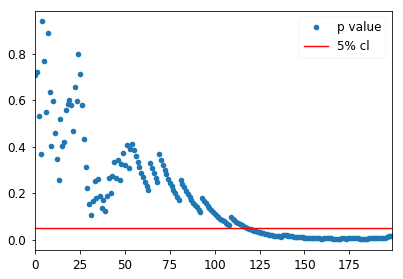

In [116]:
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(200).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- we can detect the concept drift since we predict more men than women now
- this does not mean that there is actually a concept drift, as we will see in the next example
- for p(hair) we need a larger sample size to detect some changes: whatever this change was

In [117]:
# p(height)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_1['height']:
    samples.append(element)
    k, p = ks_2samp(X_val['height'], samples)
    ks_stats.append(p)

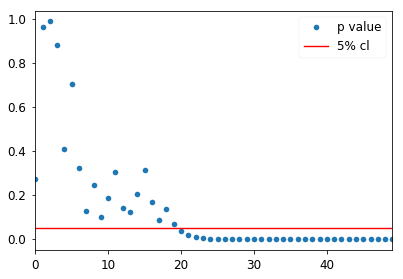

In [120]:
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(50).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- p value drops fast (height has changed the most)

### Szenario 2: Due to the pills 70 % of the women died. Those who survived did not take the pill anymore and have the ordinary height and hair length.

In [122]:
df_test_2 = df_test.copy()

In [126]:
df_f = df_test_2[df_test_2.sex == 0]
df_m = df_test_2[df_test_2.sex == 1]

In [134]:
#df_m

In [130]:
df_f_new = df_f.head(360)

In [131]:
df_test_2 = pd.concat([df_f_new, df_m], axis=0)

In [135]:
df_test_2.head()

,hair,height,sex
7088,11.972783,157.409579,0
10866,44.488123,161.909165,0
10047,6.834302,188.146544,0
10036,24.746039,165.169465,0
7562,1.141354,135.757597,0


/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


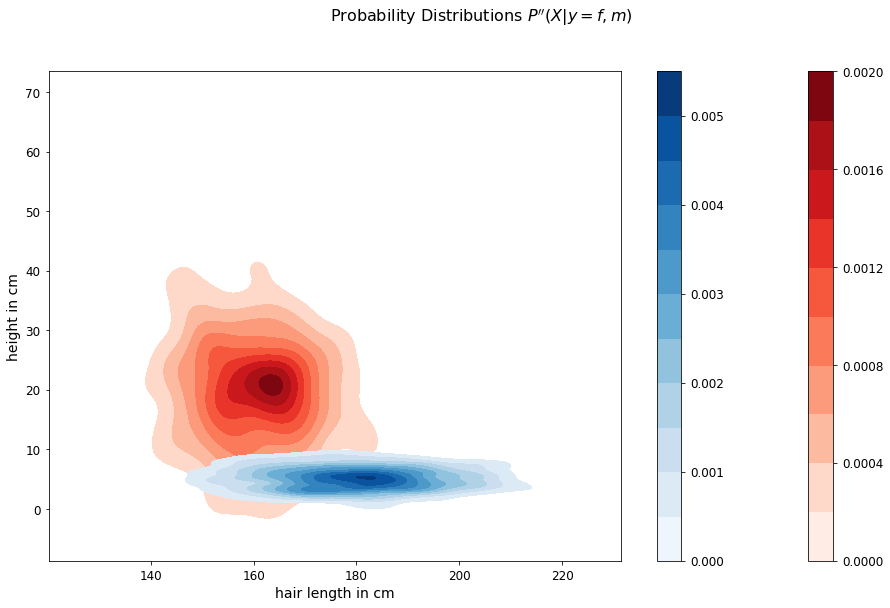

In [136]:
# p(X| y=f,m)
fig, ax = plt.subplots(nrows=1, figsize=(16,9))
df_m = df_test_2[df_test['sex'] == 1]
df_f = df_test_2[df_test['sex'] == 0]
sns.kdeplot(df_f['height'], df_f['hair'], ax=ax,cmap="Reds", shade=True, shade_lowest=False, cbar=True, label='f')
sns.kdeplot(df_m['height'], df_m['hair'], ax=ax,cmap="Blues", shade=True, shade_lowest=False, cbar=True, label='m' )

fig.suptitle(r"Probability Distributions $P''(X\vert y=f,m)$")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
fig.savefig('cond_ppprimex.pdf', bbox_inches='tight')


#ax.legend()
#sns.jointplot(data=df_test[df_test['sex'] == 1], x='height', y='hair', kind='kde', ax=ax)

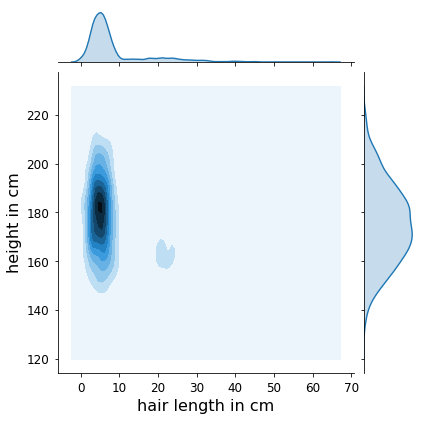

In [137]:
# p(x)
g = sns.jointplot(data=df_test_2, x='hair', y='height', kind='kde')
g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
#g.set_axis_labels('hair length in cm', 'height in cm', fontsize=16)
g.savefig('joint_ppprimex.pdf', bbox_inches='tight')

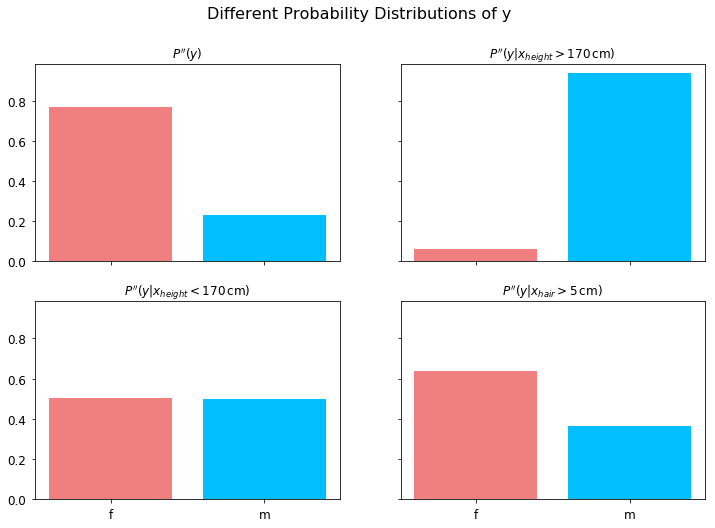

In [138]:
# p(y)

counts_full = df_test_2['sex'].value_counts(normalize=True)
counts_cond1 = df_test_2[df_test_2['height'] > 170]['sex'].value_counts(normalize=True).sort_values()
counts_cond2 = df_test_2[df_test_2['height'] < 170]['sex'].value_counts(normalize=True)
counts_cond3 = df_test_2[df_test_2['hair'] > 5]['sex'].value_counts(normalize=True)
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,8))
fig.suptitle("Different Probability Distributions of y")
ax[0,0].bar(x=['f', 'm'], height=counts_full.values, color=['lightcoral','deepskyblue'])
ax[0,1].bar(x=['f', 'm'], height=counts_cond1.values, color=['lightcoral','deepskyblue'])
ax[1,0].bar(x=['f', 'm'], height=counts_cond2.values, color=['lightcoral','deepskyblue'])
ax[1,1].bar(x=['f', 'm'], height=counts_cond3.values, color=['lightcoral','deepskyblue'])

ax[0,0].set_title(r"$P''(y)$")
ax[0,1].set_title(r"$P''(y\vert x_{height} > 170 \, \mathrm{cm})$")
ax[1,0].set_title(r"$P''(y\vert x_{height} < 170\, \mathrm{cm})$")
ax[1,1].set_title(r"$P''(y\vert x_{hair} > 5\, \mathrm{cm})$")

fig.savefig('cond_ppprimey.pdf', bbox_inches='tight')

[]

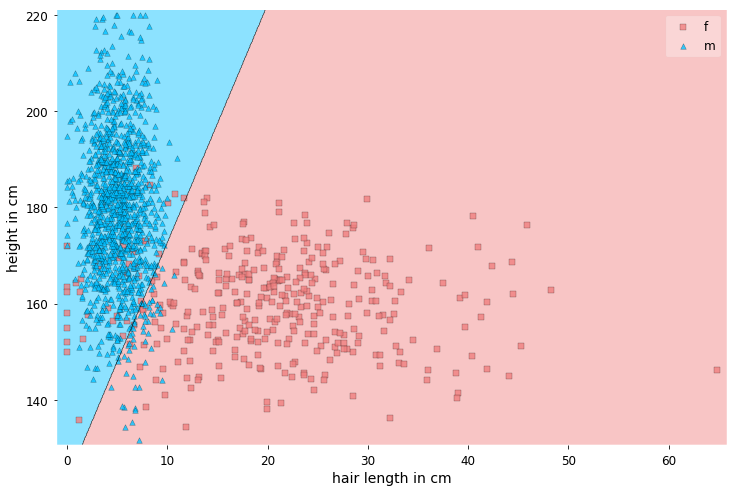

In [140]:
# DECISION BOUNDARY PLOT
fig, ax = plt.subplots(nrows=1, figsize=(12,8))
plot_decision_regions(X=df_test_2[['hair', 'height']].values, y=df_test_2['sex'].values, clf=clf, ax=ax, colors='lightcoral,deepskyblue', legend=True, contourf_kwargs={'linestyles':['dotted', 'dotted']} )
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['f', 'm'], 
           framealpha=0.3, scatterpoints=1)
#norml = colors.BoundaryNorm(lev, 256)
#plot_decision_regions(X=df_test_1[['hair', 'height']].values, y=df_test_1['sex'].values, clf=clf_new_1, ax=ax, colors='lightcoral,deepskyblue', legend=False, contourf_kwargs={'alpha':0.0, 'norm':'default'})
#fig.suptitle("Logistic Regression Decision Boundary")
#fig.suptitle("Logistic Regression Decision Boundary")
ax.set_xlabel('hair length in cm')
ax.set_ylabel('height in cm')
#fig.tight_layout()
#legend = ax.legend(ax.get_legend(),labels=['m', 'f'])
#legend.set
fig.savefig('Decision_Boundary_ppprime.pdf', bbox_inches='tight')
ax.lines

- real decision boundary has actually not changed
- dataset is a bit more imbalanced now

### bayes
$$P'(Y\vert X) = \frac{P'(X\vert Y) P'(Y)}{P'(X)} = \frac{P'(X\vert Y) P'(Y)}{P'(X)}$$

- P'(X\vert Y) changed only slightly (depends on the women who died, actually it is possible that it has not changed)
- P'(Y) changed
- P'(X) changed

let's have a look at our observables


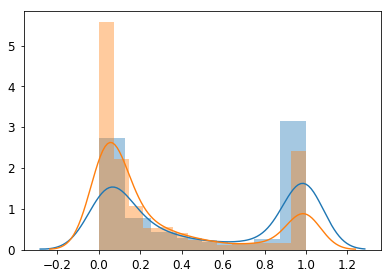

In [146]:
proba_hist = clf.predict_proba(X_val)[:,0]
proba_new = clf.predict_proba(df_test_2[['hair', 'height']])[:,0]
proba_comb = np.concatenate([proba_hist,proba_new])

sns.distplot(proba_hist)
sns.distplot(proba_new)

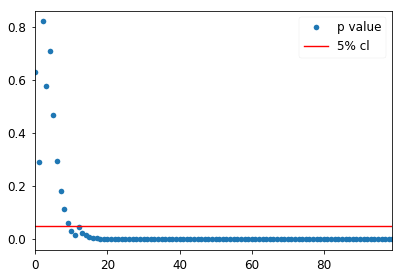

In [147]:
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in proba_new:
    samples.append(element)
    k, p = ks_2samp(proba_hist, samples)
    ks_stats.append(p)
    
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

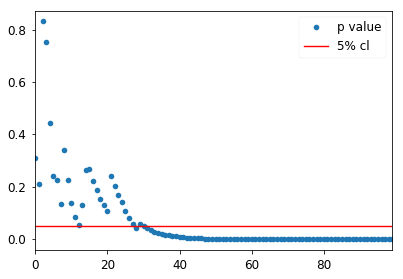

In [148]:
# p(height)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_2['height']:
    samples.append(element)
    k, p = ks_2samp(X_val['height'], samples)
    ks_stats.append(p)
    
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

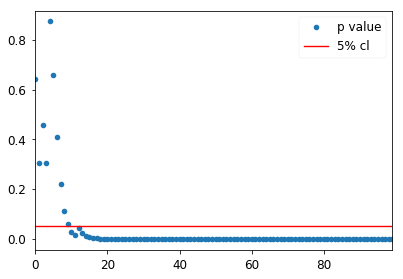

In [149]:
# p(height)
from scipy.stats import ks_2samp
ks_stats = []
samples = []
for element in df_test_2['hair']:
    samples.append(element)
    k, p = ks_2samp(X_val['hair'], samples)
    ks_stats.append(p)
    
# comparison of model predictions
fig, ax = plt.subplots(nrows=1)
pd.Series(ks_stats).head(100).plot(ax=ax, linestyle='None', marker='o', label='p value')
ax.axhline(0.05, c='r', label='5% cl')
ax.legend()

- we see similar effects as in the previous example
- however, the decision boundary has not really changed (i.e. it is still the optimal one)
- P(Y\vert X) has changed

### Szenario 3: Some men decided to become man? Makes problem very difficult

Since so many women died, some men need to become women in order to ...

In [144]:
proba_hist = clf.predict_proba(X_val)[:,0]
proba_new = clf.predict_proba(df_test_2[['hair', 'height']])[:,0]
proba_comb = np.concatenate([proba_hist,proba_new])

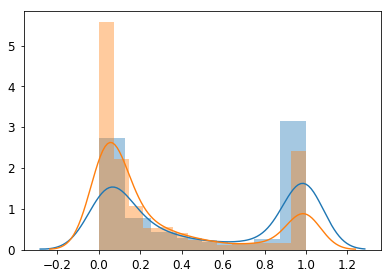

In [145]:
sns.distplot(proba_hist)
sns.distplot(proba_new)